# Dynamic Asset Allocation With the Logistic Function

**Thought experiment:**  
Use the logistic function for allocation in a two asset model, where the portfolio value $V_t$ depend on the development in  

- Risky asset $S_t$ with dynamics $dS_t = \mu S_t dt+\sigma S_t dW_t$
- Risk free asset $B_t$ with dynamics $dB_t = rB_tdt$

and some dynamic weighting scheme. The exposure in the risky asset at time $t$ is given by:  

$e_t(\theta;X_t)={\frac {1}{1+e^{-\theta X_t}}}$  

where the parameter $\theta$ determine the rate of adjustment in $e_t$ upon change in $X_t$. Consider two different approaches to asset allocation: 

1. **Portfolio-based strategy:** $X_t$ is the t-day portfolio return,  $X_t = log(\frac{V_t}{V_0})$
2. **Market-based strategy:** $X_t$ is the t-day risky asset return,  $X_t = log(\frac{S_t}{S_0})$

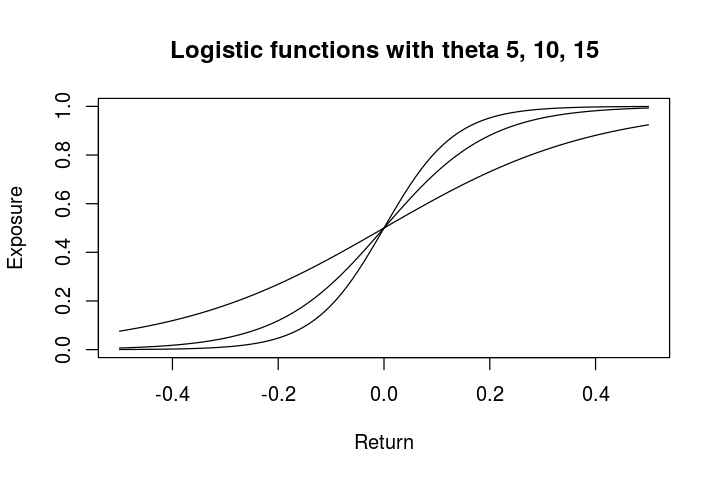

In [16]:
R <- seq(-0.5,0.5, by = 0.01)
options(repr.plot.width = 6, repr.plot.height = 4)
plot(R, (1/(1+exp(-10*R))), type = "l", ylab = "Exposure", xlab = "Return", main = "Logistic functions with theta 5, 10, 15")
lines(R, 1/(1+exp(-5*R)))
lines(R, 1/(1+exp(-15*R)))

The portfolio value $V_t$ dynamics is given by  
\begin{eqnarray}
dV_t &=& \mu e_t V_t dt+\sigma e_t V_t dW_t + r(1-e_t)V_tdt \\
&=& V_t(\mu e_t +r(1-e_t)dt + \sigma e_t V_t dW_t)
\end{eqnarray}

**Solve the stochastic differential equation for the two approaches**  

Note: If we have positive drift, over time everything can be allocated to the risky asset. We could combine the model above with a regime-switching model, to "reset" the $V_0$ when we believe to cross over to a new market environment (bull/ bear market).

## 1. $X_t$ is the t-day portfolio return,  $X_t = log(\frac{V_t}{V_0})$ 

## 2. $X_t$ is the t-day risky asset return,  $X_t = log(\frac{S_t}{S_0}) = (\mu -{\frac {\sigma ^{2}}{2}})t+\sigma W_{t}$ 

R code used for hedging commodities, implemented with $r=0$. Here $e_t$ is interpreted as a hedge rate. Objective is to prevent $V_t$ from going too high.

In [1]:
source('sfpi_dual.R')

In [2]:
# packages
library(ggplot2)
library(reshape2)
library(GGally)

# plot options
options(repr.plot.width = 7, repr.plot.height = 3)

# number of simulations
sim <- 50

# GBM price process parameters
mu <- 0.0
sigma <- 0.2
S0 <- 100

# sfpi parameter
theta <- 30

# time
Y <- 5
N <- 250 * Y
delta <- Y/N
t <- seq (0, T, length = N + 1)

# simulation of GBM processes
Day <- 1:(N+1)
market <- data.frame(Day)
strat_market <- data.frame(Day)
strat_portfolio <- data.frame(Day)

for (i in 1:sim){
  W <- c(0, cumsum ( sqrt(delta) * rnorm (N))) 
  GBM <- S0 * exp(mu * t + sigma * W)
  PFO <- sfpi(q = 100, tdate = Day, f = GBM, theta = theta, tcost=0, int = TRUE)$PortfPrice
  PFO2 <- sfpi(q = 100, tdate = Day, f = GBM, theta = theta, tcost=0, int = TRUE)$PortfPrice2
  market <- cbind(market,GBM)
  strat_portfolio <- cbind(strat_portfolio, PFO)
  strat_market <- cbind(strat_market, PFO2)
}

colnames(market) <- c("Day",paste0("GBM",1:sim))
colnames(strat_portfolio) <- c("Day",paste0("PFO",1:sim))
colnames(strat_market) <- c("Day",paste0("PFO2",1:sim))

market_m <-melt(market, id = "Day")
strat_portfolio_m <-melt(strat_portfolio, id = "Day")
strat_market_m <-melt(strat_market, id = "Day")

market_m <- cbind(market_m,Type="Market")
strat_portfolio_m <- cbind(strat_portfolio_m,Type="PortfStrat")
strat_market_m <- cbind(strat_market_m,Type="MarketStrat")

#portfolio_melt <-melt(portfolio, id = "Day")
sim <- rbind(market_m, strat_portfolio_m, strat_market_m)

max(market[,2:dim(market)[2]])
max(strat_portfolio[,2:dim(strat_portfolio)[2]])
max(strat_market[,2:dim(strat_market)[2]])

[1] 324.2437

[1] 115.0476

[1] 140.1565

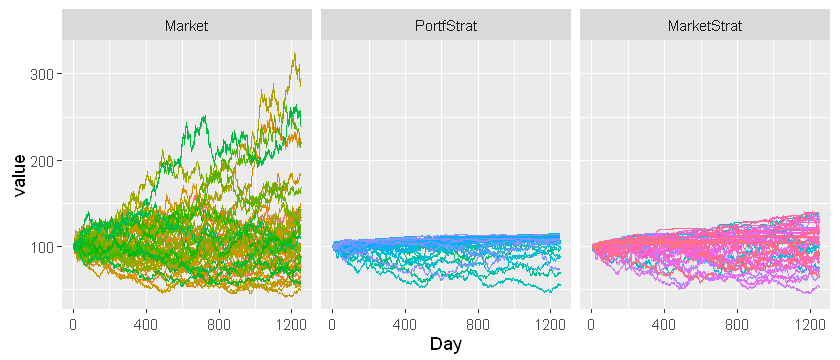

In [3]:
# the GBM market vs PortfStrat and MarketStrat
ggplot(sim,aes(x = Day, y = value, colour = variable)) + geom_line() + theme(legend.position="none") + 
facet_grid(. ~ Type)

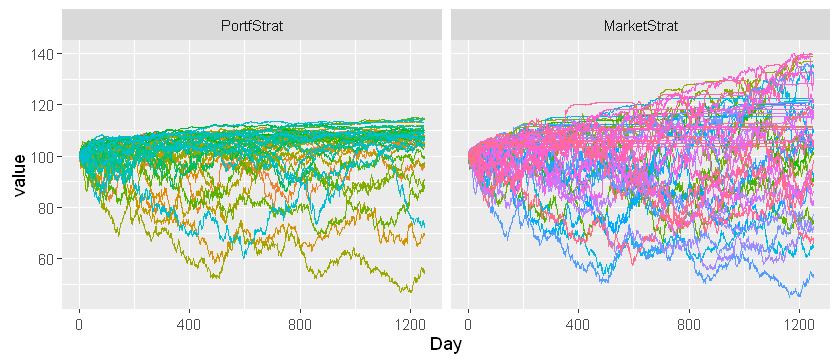

In [4]:
# PortfStrat vs MarketStrat
strat <- rbind(strat_portfolio_m, strat_market_m)
ggplot(strat,aes(x = Day, y = value, colour = variable)) + geom_line() + theme(legend.position="none") +
facet_grid(. ~ Type)

In [40]:
# define grid with possible parameter combinations
theta <- seq(50, 55, by = 1)
mu <- seq(0.01, 0.1, by = 0.01)
sigma <- seq(0.05, 0.2, by = 0.01)
param <- expand.grid(theta, mu, sigma)

In [55]:
# number of gbm simulations and initial S0 value
sim <- 50
S0 <- 100

# time
Y <- 3
N <- 250 * Y
delta <- Y/N
t <- seq (0, T, length = N + 1)

# data frame for keeping simulation results
max_df <- data.frame()

# run sim for all combinations in the parameter grid
for (i in seq_along(param[,1])){
    
    # GBM price process parameters
    mu <- param[i, 2]
    sigma <- param[i, 3]

    # sfpi parameter
    theta <- param[i, 1]

    # simulation of GBM processes
    Day <- 1:(N+1)
    market <- data.frame(Day)
    strat_market <- data.frame(Day)
    strat_portfolio <- data.frame(Day)

    for (i in 1:sim){
      W <- c(0, cumsum ( sqrt(delta) * rnorm (N))) 
      GBM <- S0 * exp(mu * t + sigma * W)
      PFO <- sfpi(q = 100, tdate = Day, f = GBM, theta = theta, tcost=0, int = TRUE)$PortfPrice
      PFO2 <- sfpi(q = 100, tdate = Day, f = GBM, theta = theta, tcost=0, int = TRUE)$PortfPrice2
      market <- cbind(market,GBM)
      strat_portfolio <- cbind(strat_portfolio, PFO)
      strat_market <- cbind(strat_market, PFO2)
    }    
    
    # append simulation results to max_df
    max_df <- rbind(max_df, c(max(strat_portfolio[,2:dim(market)[2]]), max(strat_market[,2:dim(market)[2]])))
    
}

# final data frame with parameter grid and simulation results
simres <- cbind(param, max_df)
colnames(simres) <- c('theta', 'mu', 'sigma', 'MaxPStrat', 'MaxMStrat')

In [58]:
write.csv2(simres, 'simres.csv', row.names =F)

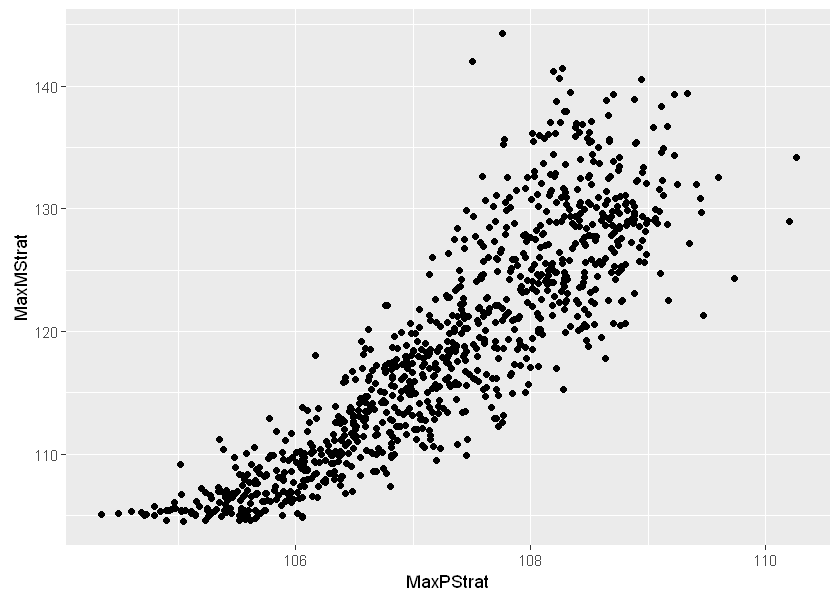

In [70]:
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(simres, aes(x = MaxPStrat, y = MaxMStrat)) + geom_point()
#ggplot(simres, aes(x = MaxPStrat, y = sigma)) + geom_point()
#ggplot(simres, aes(x = MaxPStrat, y = mu)) + geom_point()
#ggplot(simres, aes(x = MaxPStrat, y = theta)) + geom_point()


In [88]:
glm_g <- glm(simres$MaxPStrat ~ simres$theta + simres$mu + simres$sigma, family = gaussian())

In [89]:
summary(glm_g)


Call:
glm(formula = simres$MaxPStrat ~ simres$theta + simres$mu + simres$sigma, 
    family = gaussian())

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.16574  -0.26176  -0.02514   0.26695   1.76120  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  109.27723    0.38778  281.80   <2e-16 ***
simres$theta  -0.09544    0.00734  -13.00   <2e-16 ***
simres$mu      3.87547    0.43642    8.88   <2e-16 ***
simres$sigma  22.32058    0.27193   82.08   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.1508449)

    Null deviance: 1197.95  on 959  degrees of freedom
Residual deviance:  144.21  on 956  degrees of freedom
AIC: 914.51

Number of Fisher Scoring iterations: 2


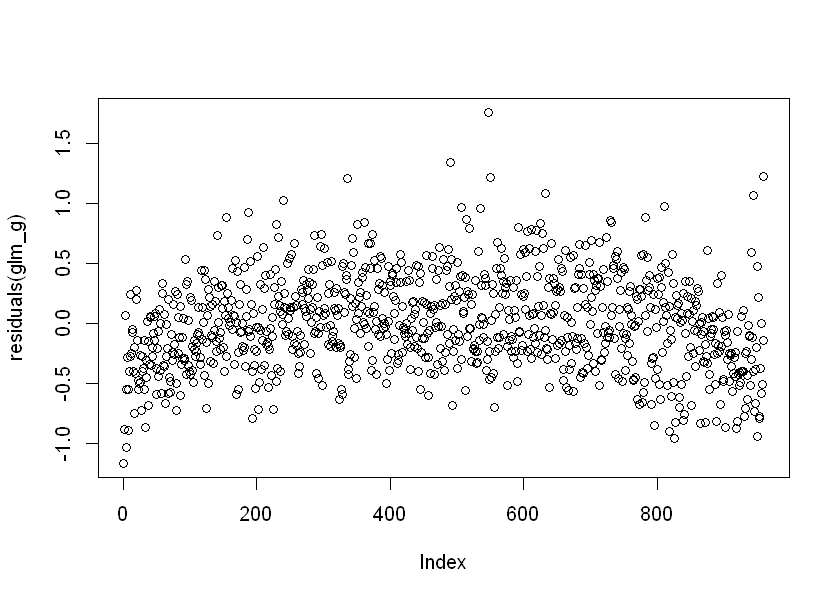

In [90]:
plot(residuals(glm_g))